# Adventures in Covariance

In [46]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from theano import tensor as tt
import arviz as az

import warnings
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
warnings.simplefilter(action="ignore", category=FutureWarning)

### Varying slopes by construction

##### Code 13.1

In [5]:
a = 3.5
b = -1
σ_a = 1
σ_b = 0.5
ρ = -0.7

##### Code 13.2

In [6]:
μ = np.array([a, b])

##### Code 13.3

In [10]:
cov_ab = sigma_a * sigma_b * rho
Σ = np.array([[σ_a**2, cov_ab], [cov_ab, σ_b]])

##### Code 13.4

##### Code 13.5

In [12]:
sigmas = np.array([σ_a, σ_b])
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

##### Code 13.6

In [13]:
N_cafes = 20

##### Code 13.7

In [15]:
np.random.seed(42)
vary_effects = np.random.multivariate_normal(mean=μ, cov=Sigma, size=N_cafes)

##### Code 13.8

In [17]:
a_cafe = vary_effects[:,0]
b_cafe = vary_effects[:,1]

##### Code 13.9

In [20]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1]/u[0])
    angle = 180 * angle / np.pi # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * chi2.ppf(level, 2)) #get size corresponding to level
        ell = Ellipse(mu[:2], v[0], v[1], 180 + angle, facecolor='None',
                      edgecolor='k',
                      alpha=(1-level)*.5,
                      lw=1.5)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
    
    return ax

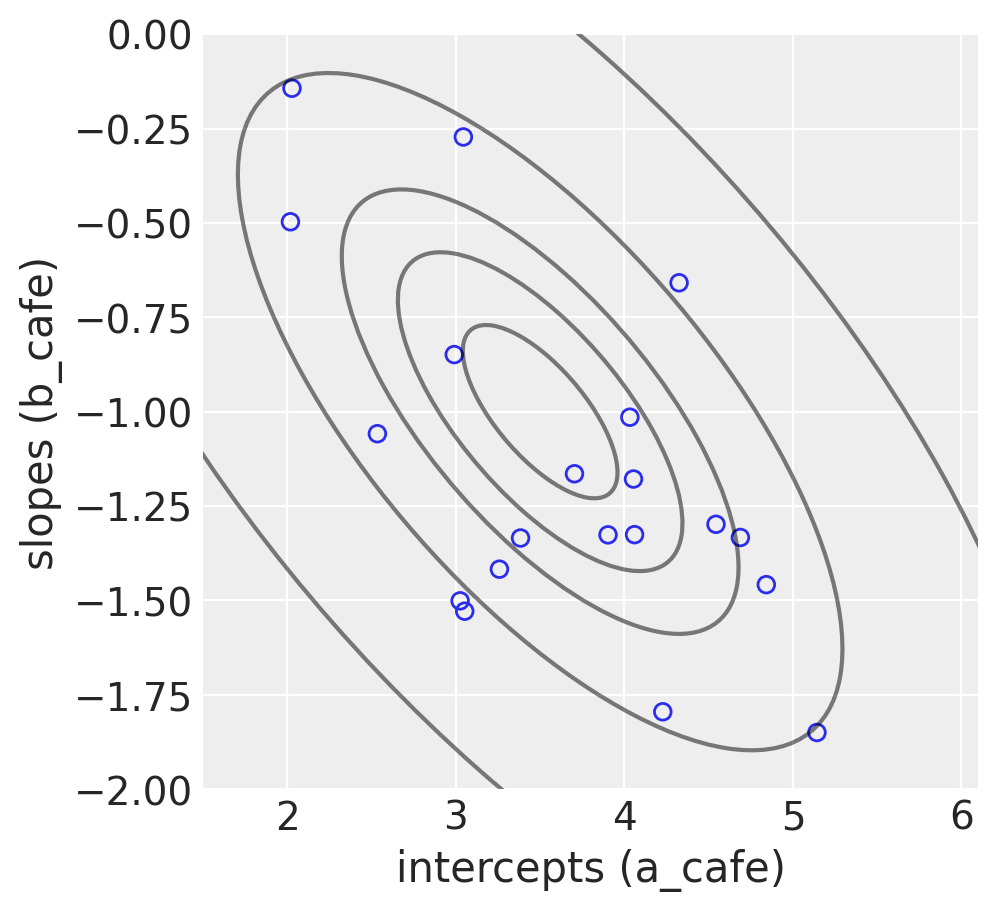

In [27]:
_, ax = plt.subplots(1, 1, figsize=(5,5))
Gauss2d(μ, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)
ax.scatter(a_cafe, b_cafe, facecolors='none', edgecolors='C0')
ax.set(ylim=(-2, 0), xlim=(1.5, 6.1), xlabel='intercepts (a_cafe)', ylabel='slopes (b_cafe)');

##### Code 13.10

In [34]:
N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes // 2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5
wait = np.random.normal(mu, sigma, N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

##### Code 13.11 & Figure 13.3

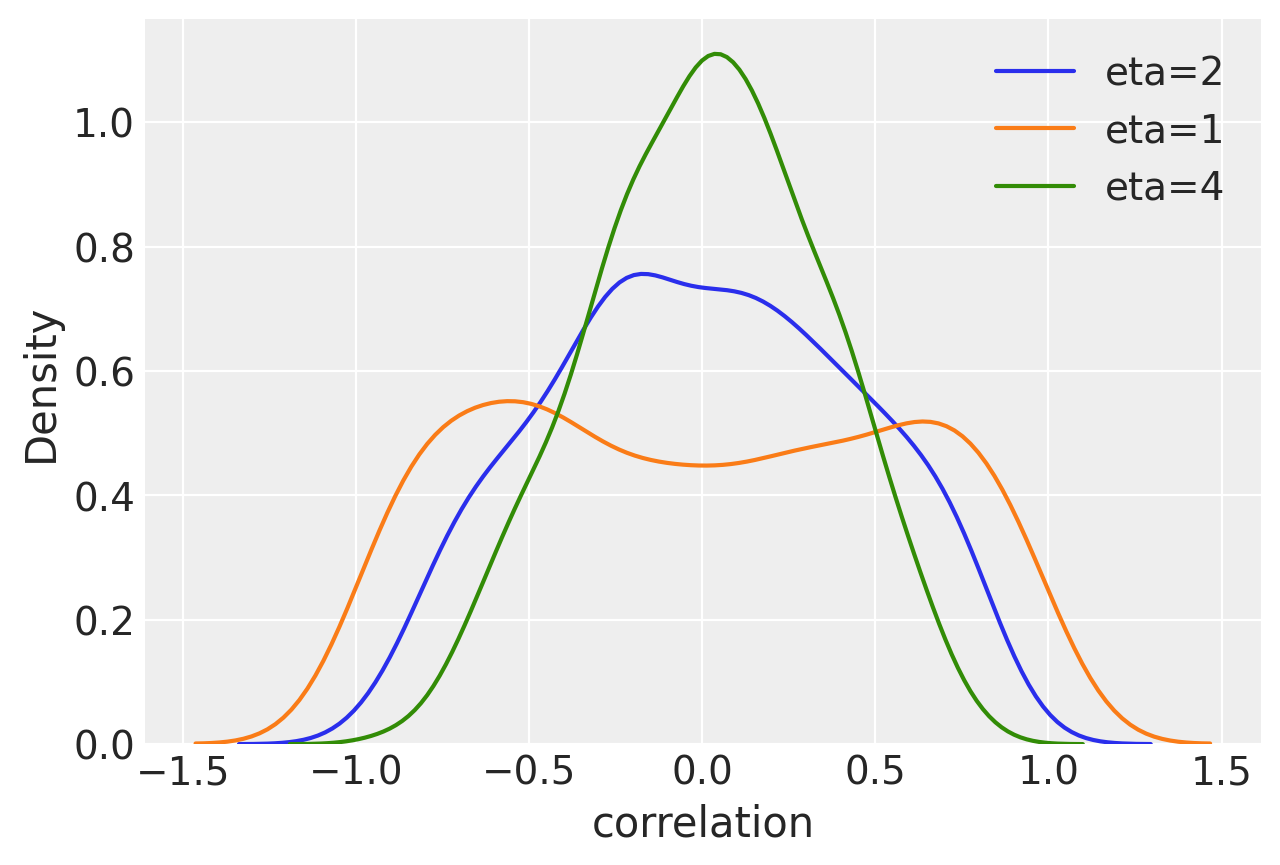

In [45]:
R = pm.LKJCorr.dist(n=2, eta=2).random(size=1000)

sns.kdeplot(R, label="eta=2")
sns.kdeplot(pm.LKJCorr.dist(n=2, eta=1).random(size=1000), label="eta=1")
sns.kdeplot(pm.LKJCorr.dist(n=2, eta=4).random(size=1000), label="eta=4")
plt.xlabel('correlation')
plt.ylabel('Density');

##### Code 13.12

In [47]:
with pm.Model() as m13_1:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov("chol_cov", eta=2, n=2, sd_dist=sd_dist)
    
    # Compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol,lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviation and rho
    sigma_ab = pm.Deterministic('sigma_cafe', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic("Rho", corr[np.triu_indices(2, k=1)])
    
    ab = pm.Normal('ab', mu=0, sd=10, shape=2)
    ab_cafe = pm.MvNormal('ab_cafe', mu=ab, chol=chol, shape=(N_cafes, 2))
    
    mu = pm.Deterministic('mu', ab_cafe[:, 0][d.cafe] + ab_cafe[:, 1][d.cafe] * d.afternoon)
    sd = pm.HalfCauchy('sigma', beta=2)
    wait = pm.Normal('wait', mu=mu, sd=sd, observed=d.wait)
    trace_m13_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ab_cafe, ab, chol_cov]
Sampling 2 chains, 0 divergences: 100%|██████████| 14000/14000 [01:14<00:00, 189.00draws/s]


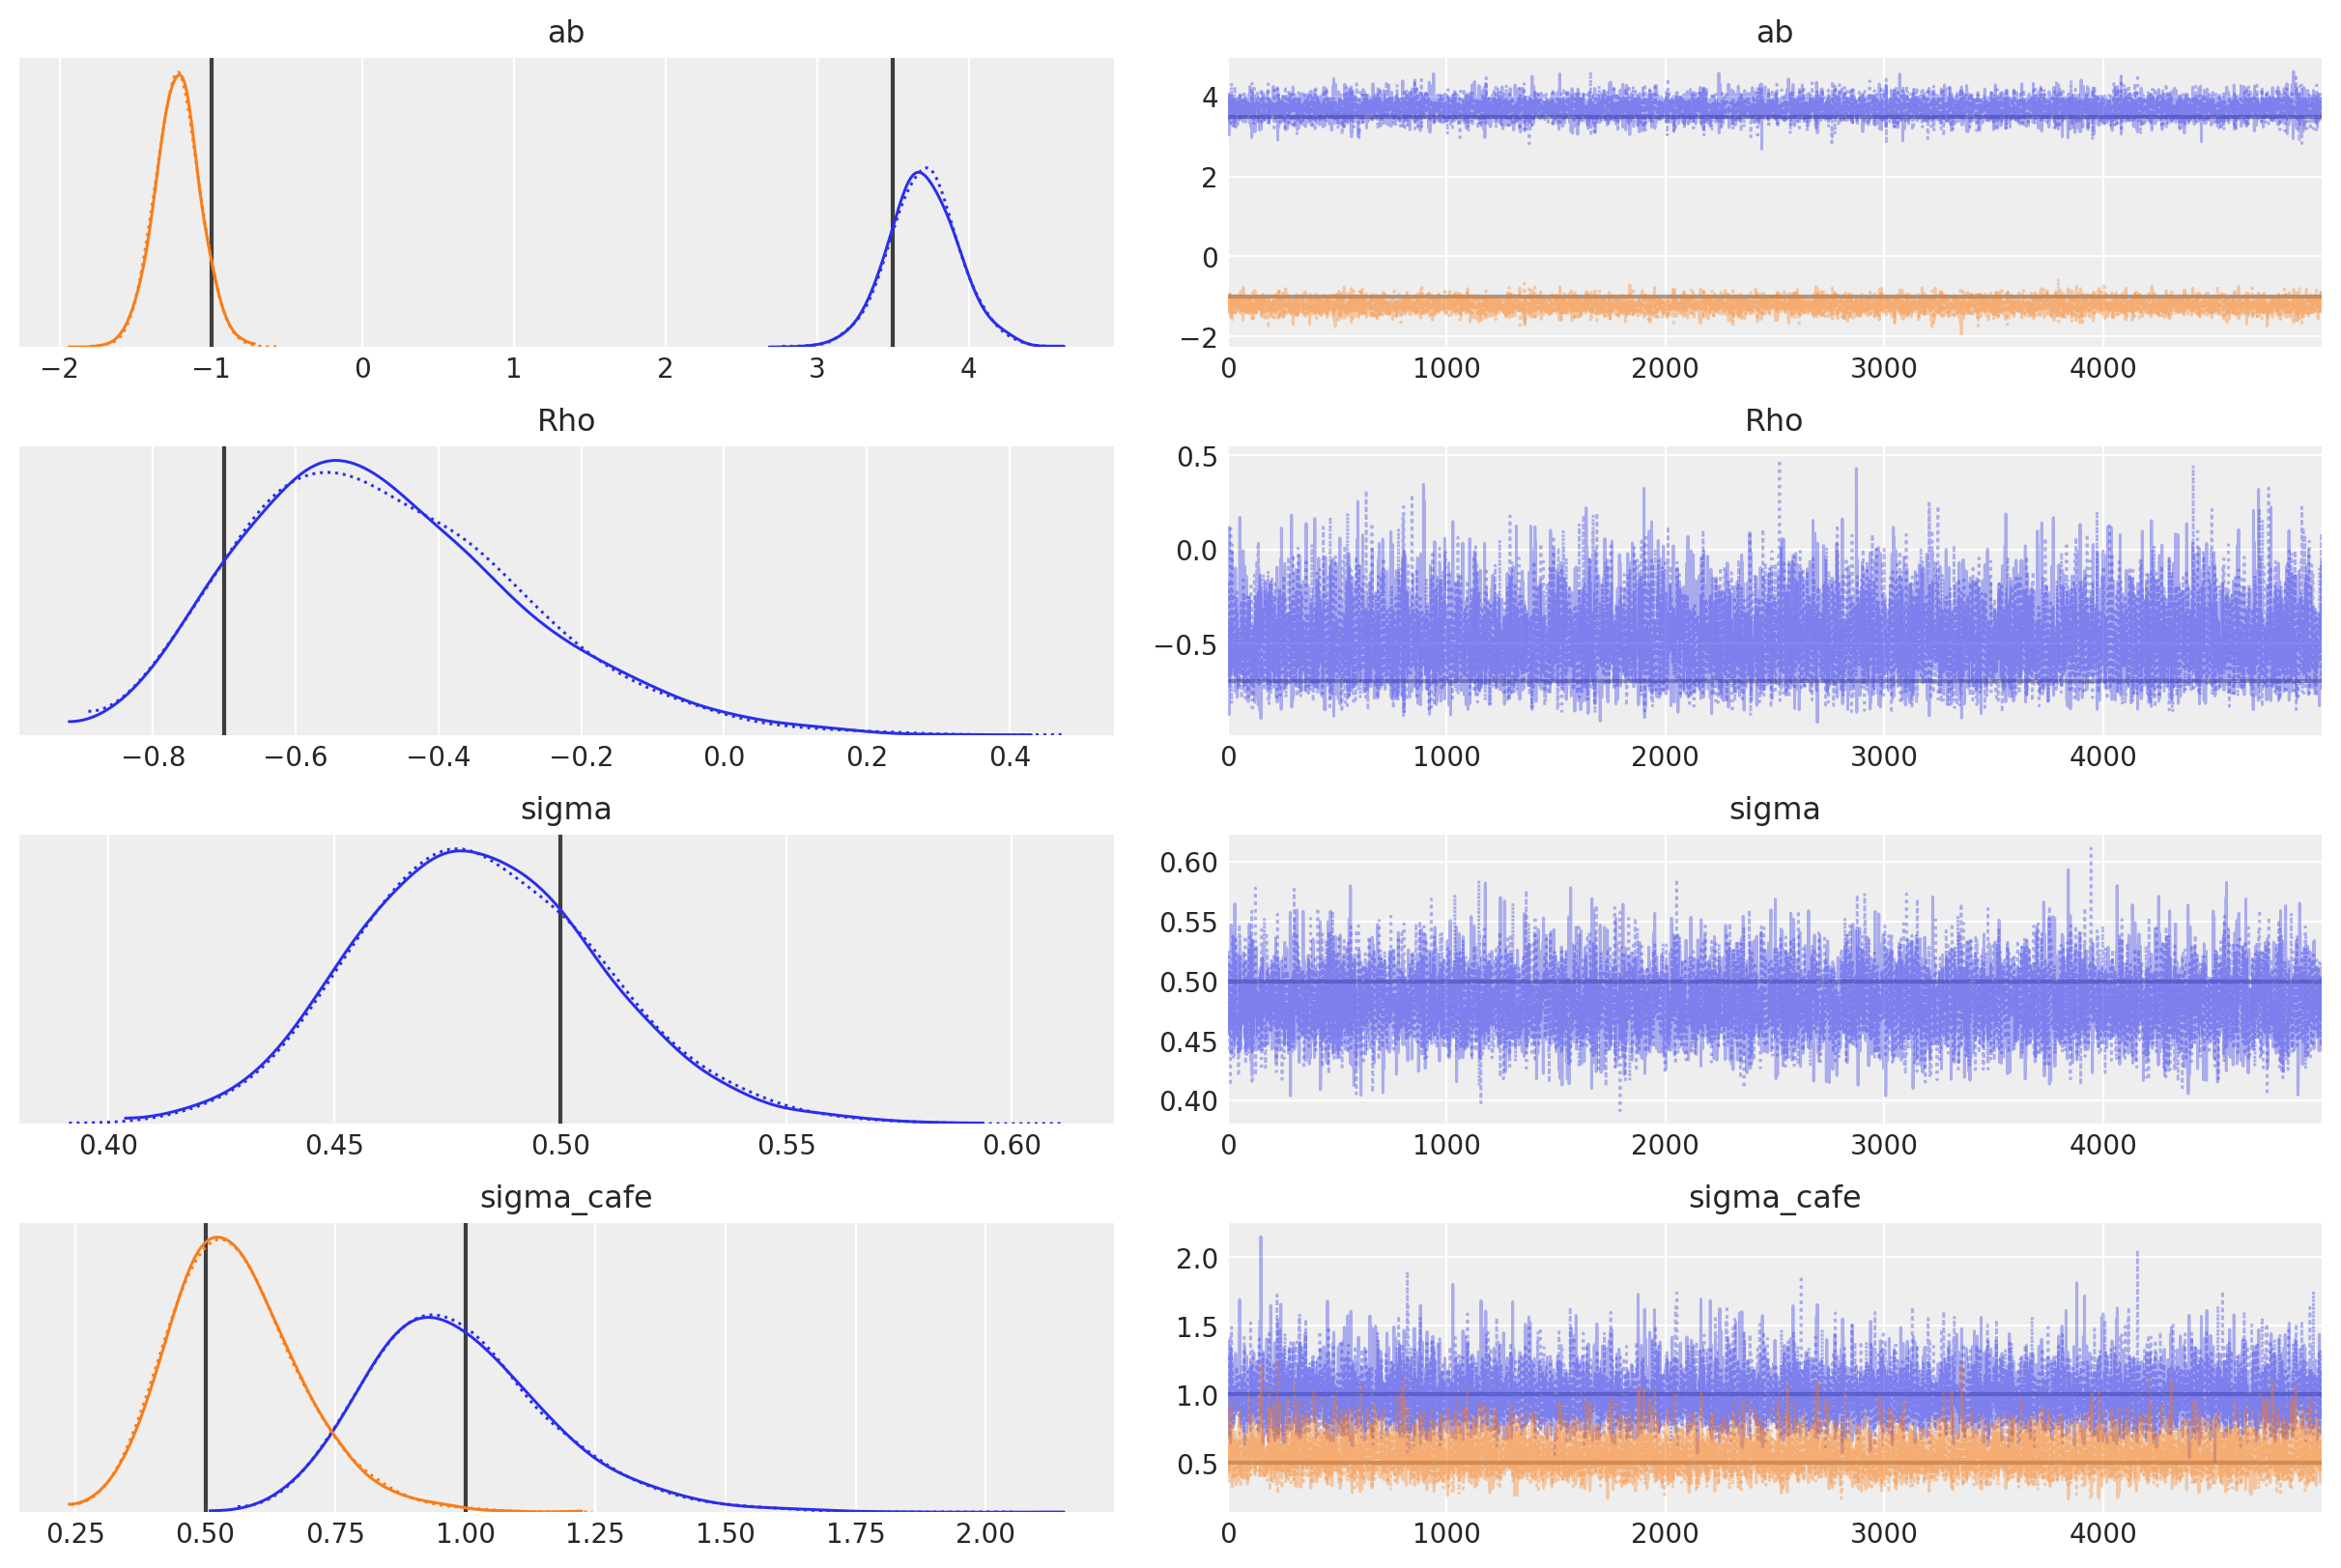

In [49]:
az.plot_trace(trace_m13_1, var_names=['ab', 'Rho', 'sigma', 'sigma_cafe'], compact=True,
              lines=[("ab", {}, Mu),
                    ("Rho", {}, rho),
                    ("sigma", {}, sigma),
                    ("sigma_cafe", {}, sigmas)]);

##### Code 13.13 & Figure 13.4

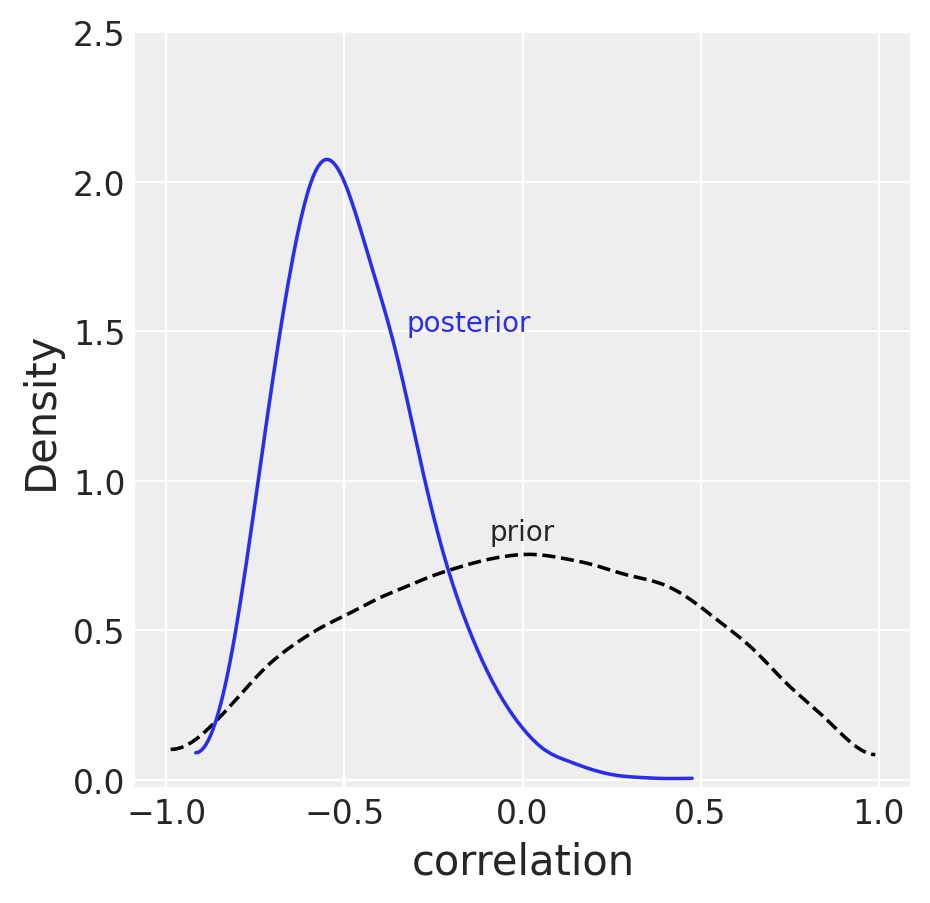

In [51]:
post = pm.trace_to_dataframe(trace_m13_1)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
az.plot_kde(R, plot_kwargs={'color':'k', 'linestyle':'--'})
ax.text(0, .8, 'prior', horizontalalignment='center')
az.plot_kde(trace_m13_1['Rho'], plot_kwargs={'color':'C0'})
ax.text(-.15, 1.5, 'posterior', color='C0', horizontalalignment='center')
ax.set_ylim(-.025, 2.5)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

##### Code 13.14

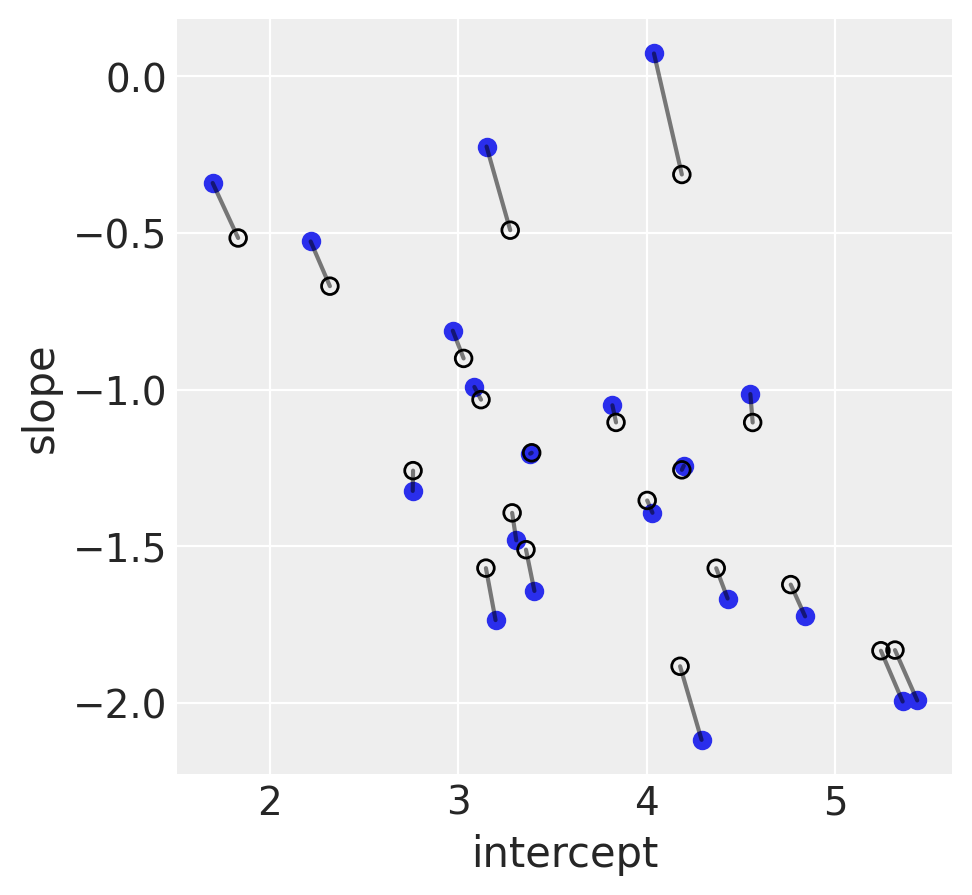

In [67]:
# compute unpooled estimates directly from data
a1b1 = (d.groupby(['afternoon', 'cafe']).mean().unstack(level=0))

a1 = a1b1.iloc[:, 0].values
b1 = a1b1.iloc[:, 1].values - a1

# extract posterior means of partially pooled estimates
a2b2 = trace_m13_1['ab_cafe'].mean(axis=0)
a2 = a2b2[:, 0]
b2 = a2b2[:, 1]

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(a1, b1)
ax.scatter(a2, b2, facecolors='none', edgecolors='k', lw=1)

ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept')
ax.set_ylabel('slope');

##### Code 13.15 & Figure 13.5a

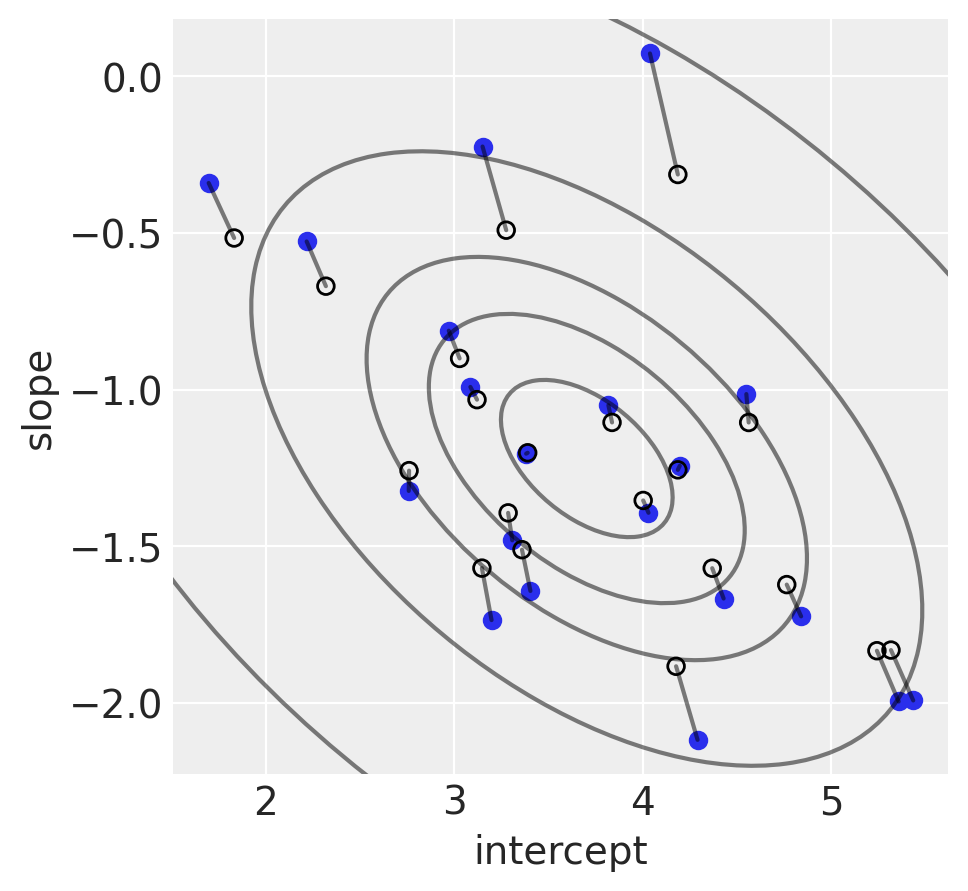

In [92]:
# compute posterior mean bivariate Gaussian
Mu_est = trace_m13_1['ab'].mean(axis=0)
chol_model = pm.expand_packed_triangular(2, trace_m13_1['chol_cov'].mean(0),lower=True).eval()
Sigma_est = np.dot(chol_model, chol_model.T)
# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
Gauss2d(Mu_est, np.asarray(Sigma_est), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)
ax.scatter(a1, b1)
ax.scatter(a2, b2, facecolors='none', edgecolors='k', lw=1)
ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14);

##### Code 13.16

In [70]:
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

In [121]:
np.cov([wait_morning_2, wait_afternoon_2])

array([[0.84559226, 0.59670931],
       [0.59670931, 0.56089795]])

##### Figure 13.5b

In [115]:
trace_m13_1['ab'].mean(axis=0)

array([ 3.70255359, -1.22027341])

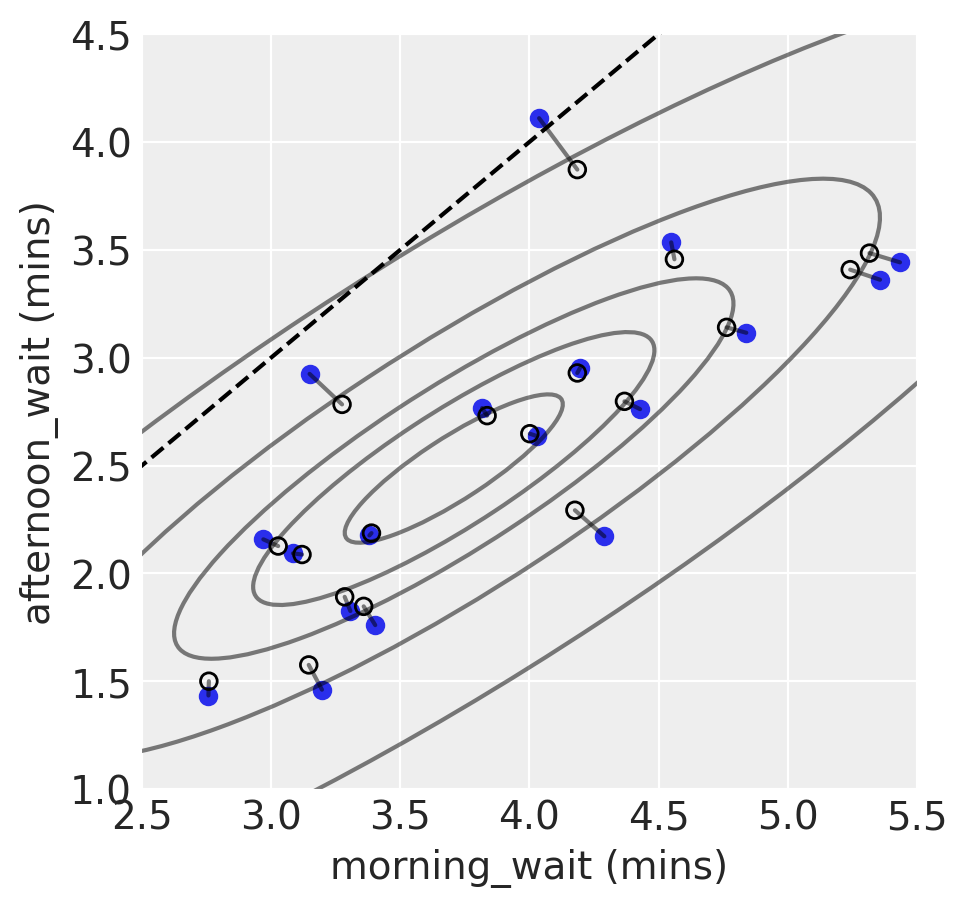

In [122]:
# compute posterior mean bivariate Gaussian
Mu_est = np.array([wait_morning_2, wait_afternoon_2]).mean(axis=1)
Sigma_est = np.cov([wait_morning_2, wait_afternoon_2])
# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
Gauss2d(Mu_est, np.asarray(Sigma_est), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)
ax.scatter(wait_morning_1, wait_afternoon_1)
ax.scatter(wait_morning_2, wait_afternoon_2, facecolors='none', edgecolors='k', lw=1)
ax.plot(np.arange(7), np.arange(7), 'k--')
ax.plot([wait_morning_1, wait_morning_2], [wait_afternoon_1, wait_afternoon_2], 'k-', alpha=.5)
ax.set_xlabel('morning_wait (mins)', fontsize=14)
ax.set_ylabel('afternoon_wait (mins)', fontsize=14)
ax.set(xlim=(2.5, 5.5), ylim=(1, 4.5));

### Example: Admission decisions and gender

##### Code 13.17

In [126]:
d = pd.read_csv("../data/UCBadmit.csv", sep=";")
d["male"] = (d["applicant.gender"] == "male").astype(int)
d["dept_id"] = pd.Categorical(d.dept).codes
d.head()

,dept,applicant.gender,admit,reject,applications,male,dept_id
1,A,male,512,313,825,1,0
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,0,1
5,C,male,120,205,325,1,2


##### Code 13.18

In [127]:
with pm.Model() as m13_2:
    a = pm.Normal("a", 0, 10)
    bm = pm.Normal("bm", 0, 1)
    sigma_dept = pm.HalfCauchy("sigma_dept", beta=2)
    a_dept = pm.Normal("a_dept", a, sigma_dept, shape=d.dept_id.nunique())
    p = pm.Deterministic("p", pm.math.invlogit(a_dept[d.dept_id] + bm * d.male))
    admit = pm.Binomial("admit", p=p, n=d.applications, observed=d.admit)
    trace_m13_2 = pm.sample(4500, tune=500)

az.summary(trace_m13_2, credible_interval=0.89, var_names=["~p"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dept, sigma_dept, bm, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [00:22<00:00, 443.65draws/s]
/Users/hamzaiqb/Library/Caches/pypoetry/virtualenvs/statrethinking-4VhjB98F-py3.8/lib/python3.8/site-packages/arviz/utils.py:652: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.58,0.63,-1.75,0.63,0.01,0.01,6772.66,5293.03,7725.01,4599.02,1.0
bm,-0.09,0.08,-0.25,0.06,0.00,0.00,5215.81,5153.81,5216.35,5749.41,1.0
a_dept[0],0.67,0.10,0.49,0.86,0.00,0.00,5960.64,5950.14,5953.69,6977.13,1.0
a_dept[1],0.63,0.11,0.40,0.83,0.00,0.00,6756.63,6671.79,6749.69,6782.20,1.0
a_dept[2],-0.58,0.07,-0.73,-0.45,0.00,0.00,11201.54,10986.44,11207.72,6850.38,1.0
a_dept[3],-0.62,0.08,-0.78,-0.46,0.00,0.00,8424.30,8356.92,8430.97,6822.95,1.0
a_dept[4],-1.06,0.10,-1.24,-0.87,0.00,0.00,12711.98,12711.98,12657.57,6717.26,1.0
a_dept[5],-2.61,0.16,-2.90,-2.32,0.00,0.00,11493.31,11377.80,11529.93,6858.64,1.0
sigma_dept,1.46,0.56,0.66,2.45,0.01,0.01,6098.03,5303.57,8055.29,6249.32,1.0


##### Code 13.19

In [147]:
with pm.Model() as m13_3:
    a = pm.Normal("a", 0, 10)
    bm = pm.Normal("bm", 0, 1)
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov("chol_cov", eta=2 ,n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic("S", pm.math.dot(chol, chol.T))
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu = pm.MvNormal('ab_dept', mu=tt.stack([a, bm]), chol=chol, shape=(d.dept.nunique(), 2))
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    bm_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    p = pm.math.invlogit(mu[d.dept_id, 0] + mu[d.dept_id, 1] * d.male)
    admit = pm.Binomial('admit', p=p, n=d.applications, observed=d.admit)
    
    trace_m13_3 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_dept, chol_cov, bm, a]
Sampling 2 chains, 53 divergences: 100%|██████████| 12000/12000 [01:19<00:00, 151.82draws/s]
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


##### Code 13.20

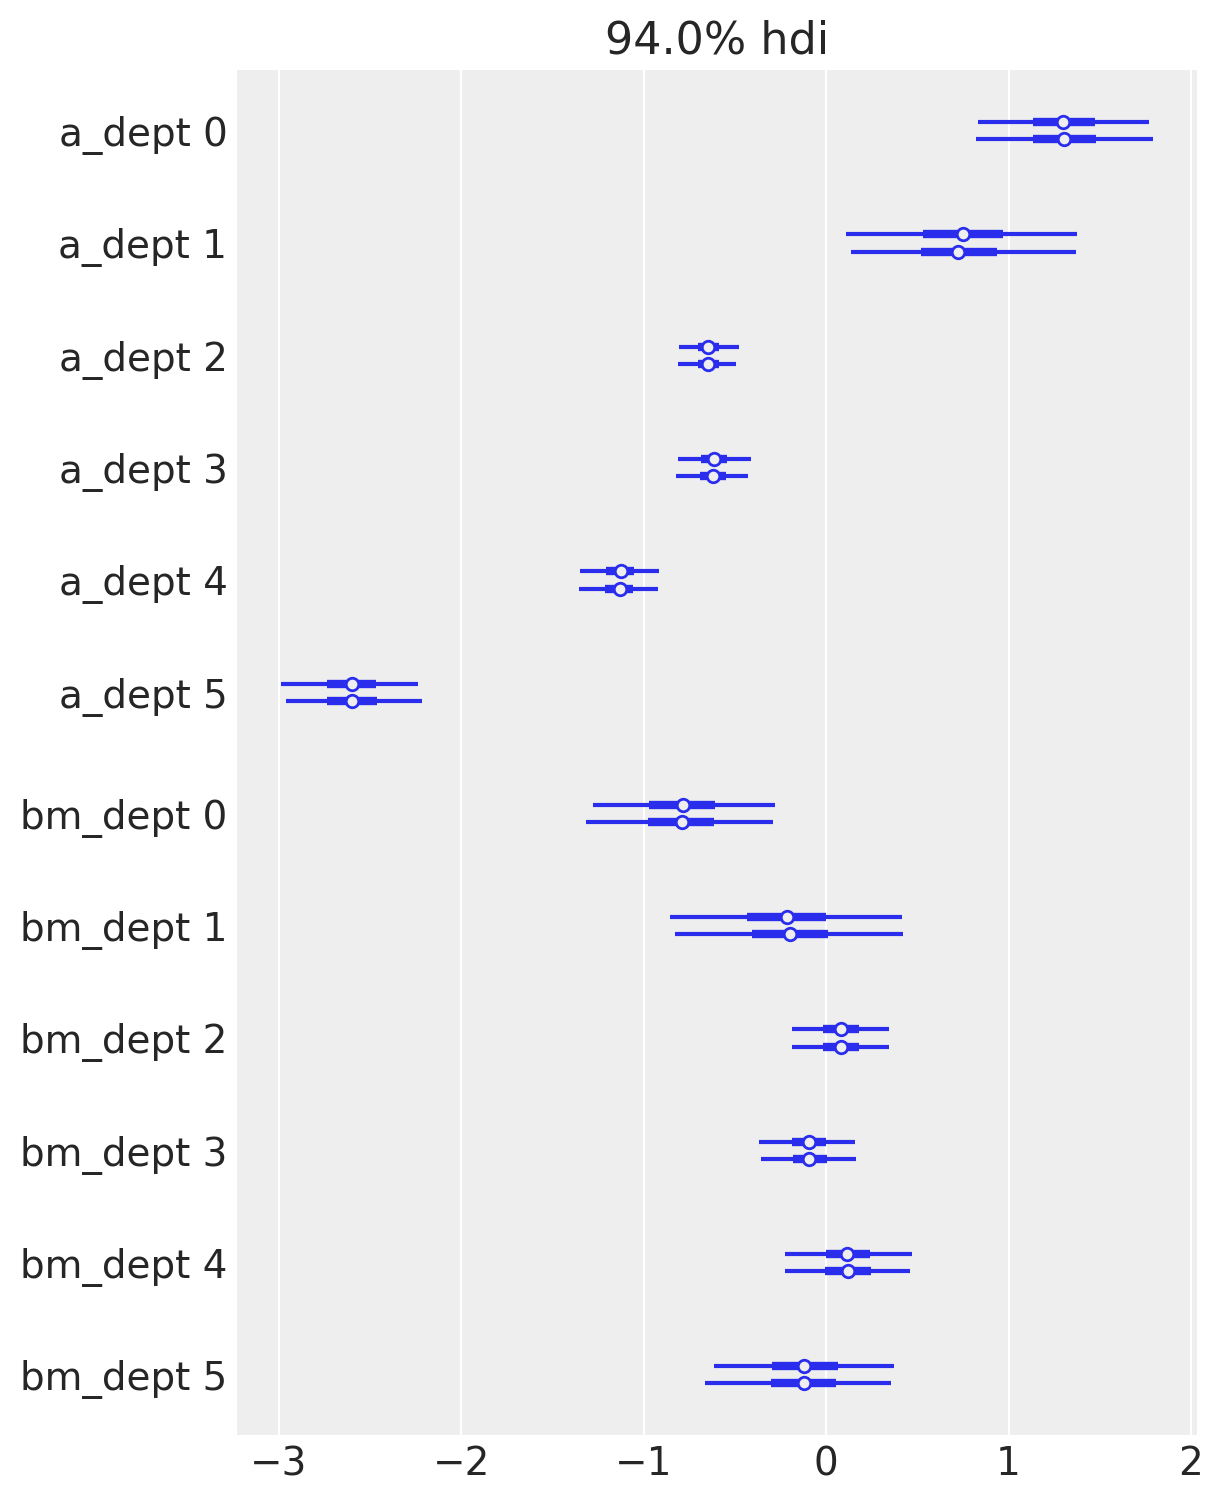

In [148]:
az.plot_forest(trace_m13_3, var_names=["a_dept", "bm_dept"]);

##### Code 13.21 & Figure 13.6a

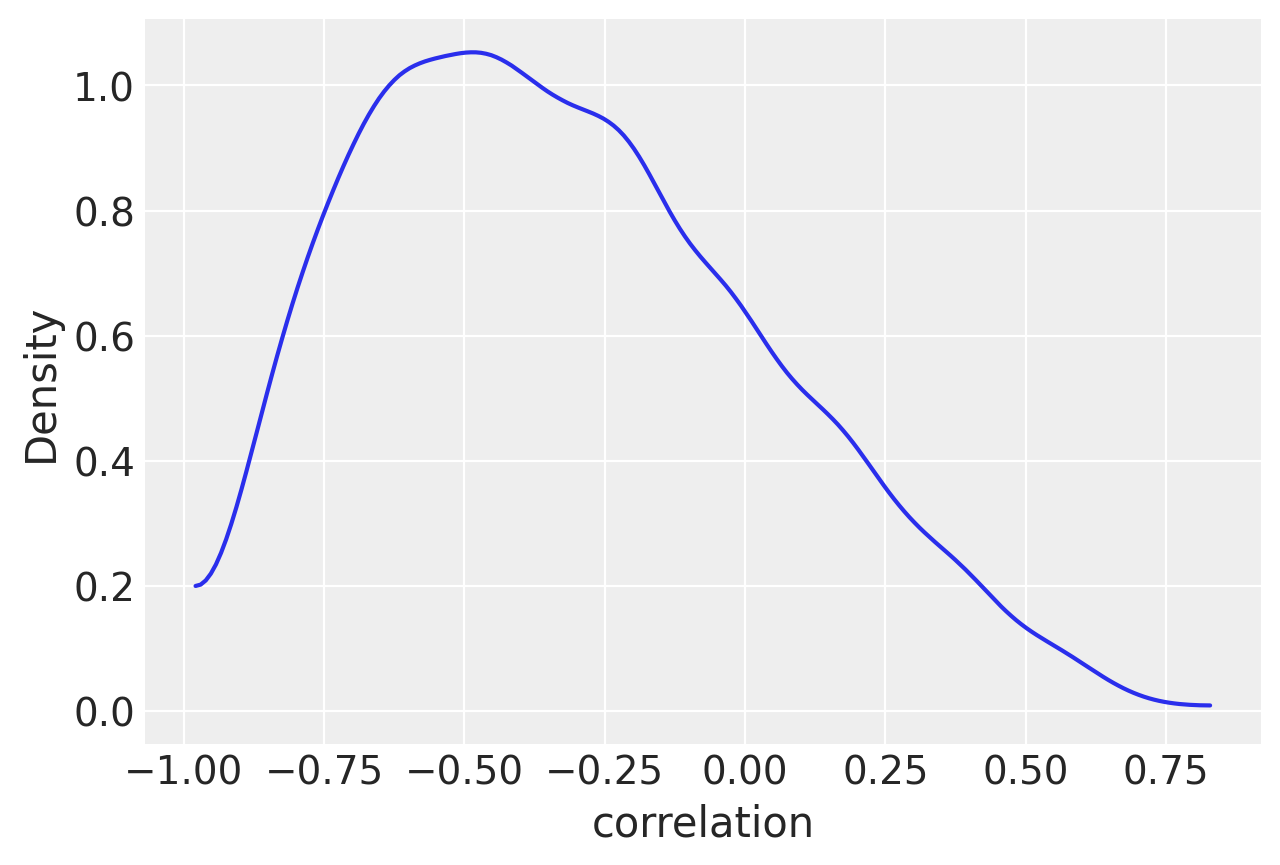

In [149]:
az.plot_kde(trace_m13_3["Rho"])
plt.xlabel("correlation")
plt.ylabel("Density");

##### Figure 13.6b

NOT SURE HOW TO REPLICATE THE BETA FOR THE UNPOOLED PART

In [177]:
d

,dept,applicant.gender,admit,reject,applications,male,dept_id
1,A,male,512,313,825,1,0
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,0,1
5,C,male,120,205,325,1,2
6,C,female,202,391,593,0,2
7,D,male,138,279,417,1,3
8,D,female,131,244,375,0,3
9,E,male,53,138,191,1,4
10,E,female,94,299,393,0,4


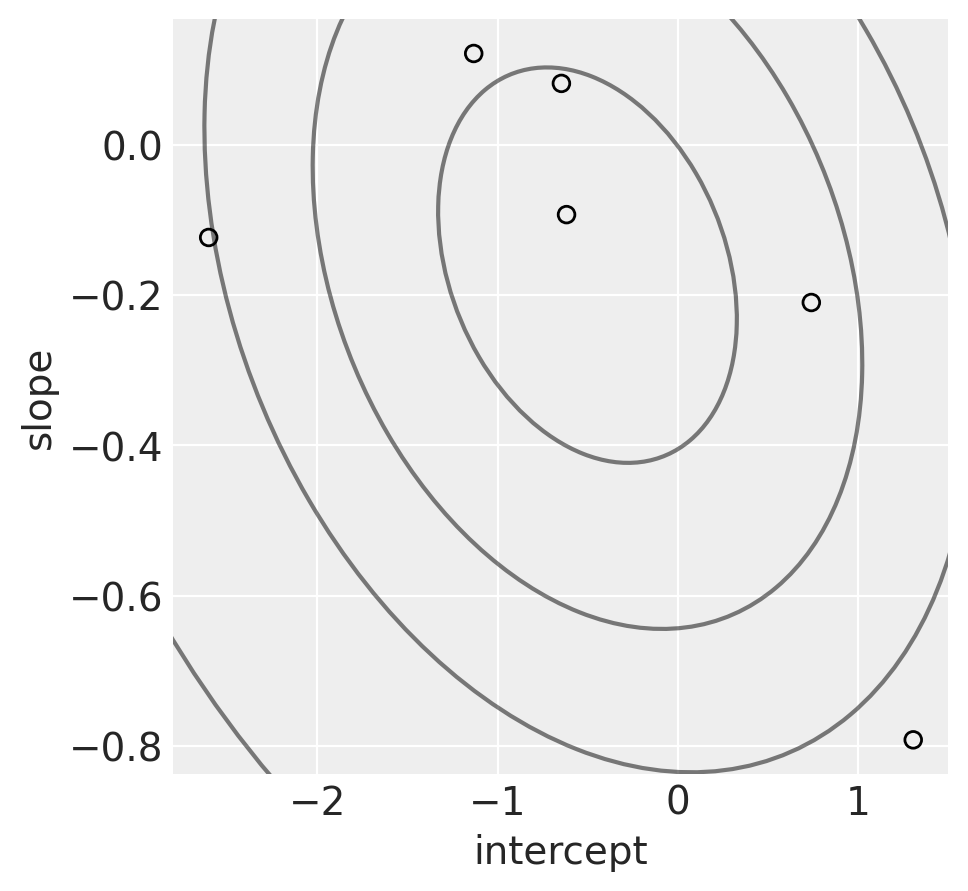

In [176]:
# compute posterior mean bivariate Gaussian
Mu = np.array([trace_m13_3["a"].mean(), trace_m13_3["bm"].mean()])
cov = trace_m13_3["S"].mean(axis=0)

# a1 = trace_m13_2["a_dept"].mean(axis=0)
a2 = trace_m13_3["a_dept"].mean(axis=0)

# b1 = trace_m13_2["bm"].mean(axis=0)
b2 = trace_m13_3["bm_dept"].mean(axis=0)

# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
Gauss2d(Mu, np.asarray(cov), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)
# ax.scatter(a1, b1)
ax.scatter(a2, b2, facecolors='none', edgecolors='k', lw=1)
# ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14);


##### Code 13.22

In [178]:
with pm.Model() as m13_4:
    a = pm.Normal("a", 0, 10)
    sigma_dept = pm.HalfCauchy("sigma_dept", beta=2)
    a_dept = pm.Normal("a_dept", a, sigma_dept, shape=d.dept_id.nunique())
    p = pm.Deterministic("p", pm.math.invlogit(a_dept[d.dept_id]))
    admit = pm.Binomial("admit", p=p, n=d.applications, observed=d.admit)
    trace_m13_4 = pm.sample(4500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dept, sigma_dept, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [00:11<00:00, 903.91draws/s]


In [179]:
az.compare({f"m13_{i}": eval(f"trace_m13_{i}") for i in [2,3,4]})

/Users/hamzaiqb/Library/Caches/pypoetry/virtualenvs/statrethinking-4VhjB98F-py3.8/lib/python3.8/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/Users/hamzaiqb/Library/Caches/pypoetry/virtualenvs/statrethinking-4VhjB98F-py3.8/lib/python3.8/site-packages/arviz/stats/stats.py:670: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/hamzaiqb/Library/Caches/pypoetry/virtualenvs/statrethinking-4VhjB98F-py3.8/lib/python3.8/site

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m13_3,0,-49.5662,10.8139,0,0.769649,8.50205,0,True,log
m13_4,1,-54.91,8.89595,5.34381,0.20695,7.62139,6.83745,True,log
m13_2,2,-56.7234,11.8537,7.15725,0.0234017,2.70349,5.73372,True,log


### Example: Cross-classified chimpanzees with varying slopes

##### Code 13.23

##### Code 13.24

##### Code 13.25

##### Code 13.26

##### Code 13.27

##### Code 13.28

##### Code 13.29

##### Code 13.30

##### Code 13.31
##### Code 13.32
##### Code 13.33
##### Code 13.34
##### Code 13.35
##### Code 13.36
##### Code 13.37

In [ ]:
import sys, IPython, scipy, matplotlib, platform, statsmodels, arviz
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\nArviz {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__, arviz.__version__))
